In [48]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import poppy
import astropy.units as u
import logging
logging.basicConfig(level=logging.DEBUG)
from astropy.io import fits
from astropy.modeling import models, fitting
import tifffile
import numpy as np
import matplotlib.colors as mcolors
from astropy.stats import sigma_clip
logging.getLogger().setLevel(logging.INFO)
import photutils
import time
import datetime as dt
from numpy.linalg import lstsq
import os
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import os, re
from poppy.zernike import zernike_basis,decompose_opd
import winsound
from poppy.zernike import noll_indices, zern_name
from astropy.table import Table

# Colormap
dark_yellow = [ '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']
custom_cmap = mcolors.LinearSegmentedColormap.from_list("DarkYellow", dark_yellow)
gradient = np.linspace(0, 1, 256).reshape(1, -1)


<span style="color:green; font-size: 2.5em;">Funzioni</span>


In [49]:
##########################################################################
##########################################################################
def parse_beam_center(fn):
    bx = by = None
    with open(fn, 'r', encoding='latin-1') as f:
        for L in f:
            if 'Beam Center X [mm]' in L:
                bx = float(L.split(',')[1])
            elif 'Beam Center Y [mm]' in L:
                by = float(L.split(',')[1])
            if bx is not None and by is not None:
                break
    if bx is None or by is None:
        raise RuntimeError("Beam center not found")
    return bx, by
##########################################################################
##########################################################################
def parse_wavefront_grid(filename):
    with open(filename, 'r', encoding='latin-1') as f:
        lines = f.readlines()
    x_coords_line = None
    for i, line in enumerate(lines):
        if line.strip().startswith("y / x [mm]"):
            x_coords_line = i
            break
    if x_coords_line is None:
        raise ValueError("X coordinates line not found")
    x_coords_str = lines[x_coords_line].split(",")[1:]
    x_coords = []
    for x in x_coords_str:
        x_clean = x.strip()
        try:
            x_coords.append(float(x_clean))
        except:
            x_coords.append(np.nan) 
    y_coords = []
    wavefront_data = []
    for line in lines[x_coords_line+1:]:
        if line.strip() == "":
            continue
        parts = line.split(",")
        if len(parts) < 2:
            continue
        y_str = parts[0].strip()
        try:
            y = float(y_str)
        except:
            continue 
        vals = []
        # Keep all columns aligned with x_coords
        for v in parts[1:]:
            v_clean = v.strip()
            try:
                vals.append(float(v_clean))
            except:
                vals.append(np.nan)  
        y_coords.append(y)
        wavefront_data.append(vals)
    wf_array = np.array(wavefront_data)
    y_coords = np.array(y_coords)
    x_coords = np.array(x_coords)
    #print(f"x_coords length: {len(x_coords)}")
    #print(f"wavefront_data shape: {wf_array.shape}")
    if wf_array.shape[1] != len(x_coords):
        raise ValueError("Mismatch between wavefront columns and x coordinates")
    return x_coords, y_coords, wf_array
##########################################################################
##########################################################################
def parse_zernike_coeffs(fn, n_modes):
    coeffs = []
    in_z = False
    pat = re.compile(r'\s*(\d+),\s*-?\d+,\s*-?\d+,\s*([-\d\.eE]+)')
    with open(fn, 'r', encoding='latin-1') as f:
        for L in f:
            if L.strip().startswith('*** ZERNIKE FIT ***'):
                in_z = True
                continue
            if in_z:
                m = pat.match(L)
                if m:
                    idx, c = int(m.group(1)), float(m.group(2))
                    if idx <= n_modes:
                        coeffs.append(c)
                if len(coeffs) >= n_modes:
                    break
    return np.array(coeffs)
##########################################################################
##########################################################################
def noll_to_zernike(j):
    n = 0; j1 = j - 1
    while j1 >= n+1:
        n += 1; j1 -= n
    m = -n + 2*j1
    return n, m
##########################################################################
##########################################################################
def remap_sensor_coeffs(raw, n_modes):
    rem = np.zeros(n_modes)
    for i, c in enumerate(raw, start=1):
        tgt = {2:3, 3:2}.get(i, i)
        if tgt <= n_modes:
            rem[tgt-1] = c
    return rem
##########################################################################
##########################################################################
def parse_pupil_diameter_center(fn):
    pd = None
    pcx = None
    pcy = None
    with open(fn, 'r', encoding='latin-1') as f:
        for L in f:
            if 'Pupil Diameter X [mm]' in L:
                pd = float(L.split(',')[1])
            elif 'Pupil Center X [mm]' in L:
                pcx = float(L.split(',')[1])
            elif 'Pupil Center Y [mm]' in L:
                pcy = float(L.split(',')[1])
    if pd is None or pcx is None or pcy is None:
        raise RuntimeError("Pupil diameter or center not found")
    #print(f"Pupil diameter: {pd} mm, Center: ({pcx}, {pcy}) mm")
    return pd, pcx, pcy
##########################################################################
##########################################################################
def crop_to_square(arr):
    ny, nx = arr.shape
    size = min(ny, nx)
    startx = (nx - size) // 2
    starty = (ny - size) // 2
    return arr[starty:starty + size, startx:startx + size]
##########################################################################
##########################################################################
def fit_zernikes(x_coords, y_coords, wavefront_data, pupil_diameter, max_mode):  # maxmode=15
    # Normalize to unit pupil centered at 
    X_norm = x_coords / (pupil_diameter / 2)
    Y_norm = y_coords / (pupil_diameter / 2)
    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)
    mask = R <= 1
    wf_masked = wavefront_data[mask]
    basis_stack = zernike_basis(nterms=max_mode, rho=R, theta=Theta)
    Z_mat = np.vstack([basis_stack[j][mask] for j in range(max_mode)]).T #Stacks the Zernike modes into a matrix of shape (n_points, n_modes).
    coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wf_masked, rcond=None)
    # fitted wavefront
    wf_fit = np.full_like(wavefront_data, np.nan)
    fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(max_mode)], axis=0)
    wf_fit[mask] = fit_vals
    return coeffs, wf_fit
#######################################################################
#########################################################################
song_jojo = "B4 B4 B4 A4 B4 D5 B4 A4 B4 B4 B4 A4 B4 F4 E4 D4"
song_allstar = "C R G E E R D C C F R E E D D C"
def musichetta(song):
    base_freq = 440  # A4
    ratio = 2 ** (1/12)  # precise semitone ratio
    base_note_index = {'C': -9, 'C#': -8, 'D': -7, 'D#': -6, 'E': -5,
                       'F': -4, 'F#': -3, 'G': -2, 'G#': -1, 'A': 0,
                       'A#': 1, 'B': 2}

    def get_freq(note_with_octave):
        if note_with_octave == 'R':
            return None
        note = ''.join(filter(str.isalpha, note_with_octave))
        accidental = '#' if '#' in note_with_octave else ''
        octave = int(''.join(filter(str.isdigit, note_with_octave)) or 4)
        semitone_offset = base_note_index.get(note + accidental, 0)
        n = semitone_offset + (octave - 4) * 12
        return int(base_freq * (ratio ** n))

    def play_note(note, duration=250):
        freq = get_freq(note)
        if freq:
            winsound.Beep(freq, duration)
        else:
            time.sleep(duration / 1000)

    for note in song.split():
        play_note(note)
##########################################################################
##########################################################################

#########################################################################
##########################################################################
def zernike_wfe_analysis(file,elevation,n_modes,exclude_low,output_dir):
    results=[]
    
    if output_dir is None:
        output_dir = os.getcwd()
    os.makedirs(output_dir, exist_ok=True)
    #lettura dati
    x_coords, y_coords, wavefront_data = parse_wavefront_grid(file)
    pupil_diameter, pupil_center_x, pupil_center_y = parse_pupil_diameter_center(file)
    # griglia
    X_norm = (x_coords-pupil_center_x) / (pupil_diameter / 2)
    Y_norm = (y_coords-pupil_center_y) / (pupil_diameter / 2)
    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)
    mask = R <= 1
    # Zernike basis 
    basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
    # fit coefficienti
    Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
    coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wavefront_data[mask], rcond=None)
    # fitted wavefront
    #wavefront_total = np.full_like(wavefront_data, np.nan)
    wavefront_total = np.zeros_like(wavefront_data)
    fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
    wavefront_total[mask] = fit_vals
    
    ########################################################################################
    #for i, c in enumerate(coeffs, 1):
    #    print(f"Mode {i}: {c:.6f} ")#µm"
    #SOTTRAZIONE PRIMI TERMINI #############
    wf_low = np.zeros_like(wavefront_data)
    for j in range(exclude_low):
        wf_low[mask] += coeffs[j] * basis_stack[j][mask]
    wf_high = wavefront_total - wf_low
    
    # risultati
    residuals_total = wavefront_data - wavefront_total
    residuals_low = wavefront_data - wf_low
    residuals_high = wavefront_data - wf_high
    rms_wfe = np.sqrt(np.nanmean(residuals_high**2))
    pv_wfe = np.nanmax(residuals_high) - np.nanmin(residuals_high)
    
    results.append({
        'filename': file,
        'elevation': elevation,
        'rms_wfe': rms_wfe,
        'pv_wfe': pv_wfe,
        'coeffs': coeffs,
    })
    return results, wavefront_total, wf_low, wf_high, residuals_total, residuals_low, residuals_high
#########################################################################
##########################################################################

#########################################################################
##########################################################################

<span style="color:blue; font-size: 2.5em;">Grafici </span>

In [50]:
def plot_wavefront(x_coords, y_coords, wf_array, title=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(wf_array, extent=(x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()),
                   origin='upper', cmap='jet', aspect='auto')
    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')
    if title:
        ax.set_title(title)
    plt.colorbar(im, ax=ax, label='Wavefront Error [µm]')
    plt.show()
#######################################################################################################
#######################################################################################################
# Plotting function
def plot_wavefront_new(x_coords, y_coords, wf_array, title=None, cmap='jet'):
    # Filter out NaN values
    x_coords_valid = x_coords[~np.isnan(x_coords)]
    y_coords_valid = y_coords[~np.isnan(y_coords)]

    plt.figure(figsize=(12, 5))
    plt.imshow(wf_array, extent=(x_coords_valid.min(), x_coords_valid.max(), y_coords_valid.min(), y_coords_valid.max()),
               origin='upper', cmap=cmap, aspect='auto')
    plt.xlabel('X [mm]')
    plt.ylabel('Y [mm]')
    if title:
        plt.title(title)
    plt.colorbar(label='Wavefront Error [µm]')
    plt.show()
    #######################################################################################################
#######################################################################################################
def plot_wavefronts(x_coords, y_coords, wavefront_data, wavefront_fit):
    extent = [
    np.nanmin(x_coords),
    np.nanmax(x_coords),
    np.nanmin(y_coords),
    np.nanmax(y_coords),
]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    im0 = axs[0].imshow(wavefront_data, extent=extent, origin='upper', cmap='jet')
    axs[0].set_title('Measured Wavefront')
    axs[0].set_xlabel('X [mm]')
    axs[0].set_ylabel('Y [mm]')
    plt.colorbar(im0, ax=axs[0], label='[μm]')

    im1 = axs[1].imshow(wavefront_fit, extent=extent, origin='upper', cmap='jet')
    axs[1].set_title('Reconstructed fitted Wavefront')
    axs[1].set_xlabel('X [mm]')
    axs[1].set_ylabel('Y [mm]')
    plt.colorbar(im1, ax=axs[1], label=' [μm]')

    plt.tight_layout()
    plt.show()
#######################################################################################################
#######################################################################################################
def plot_wavefront_residuals(x_coords, y_coords, wavefront_data, wavefront_fit_2, title='Zernike Fit Residuals'):
    wavefront_fit_2 = np.nan_to_num(wavefront_fit_2, nan=0.0)
    residuals = np.nan_to_num(wavefront_data - wavefront_fit_2, nan=0.0)
    plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], residuals, title=title)

<span style="color:yellow; font-size: 2.5em;">Variabili in input </span>

In [4]:


file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus")
directory = r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus"
filenumber = 9 # sceglie il file specifico nella cartella directory
#pupil_diameter = 5.8  # mm
orders =  30
n_modes = 27
#pixel_scale = 0.150  # mm/pixel SPAZIATURE DEGLI SPOT NEL PIANO, NON LA REALE DIMENSIONE DEI PIXEL (QUELLA è 5.86 micron)



<span style="color:orange; font-size: 2.5em;">Per un solo file csv </span>

x_coords length: 74
wavefront_data shape: (45, 74)
Pupil diameter: 5.8 mm, Center: (0.05, -0.056) mm


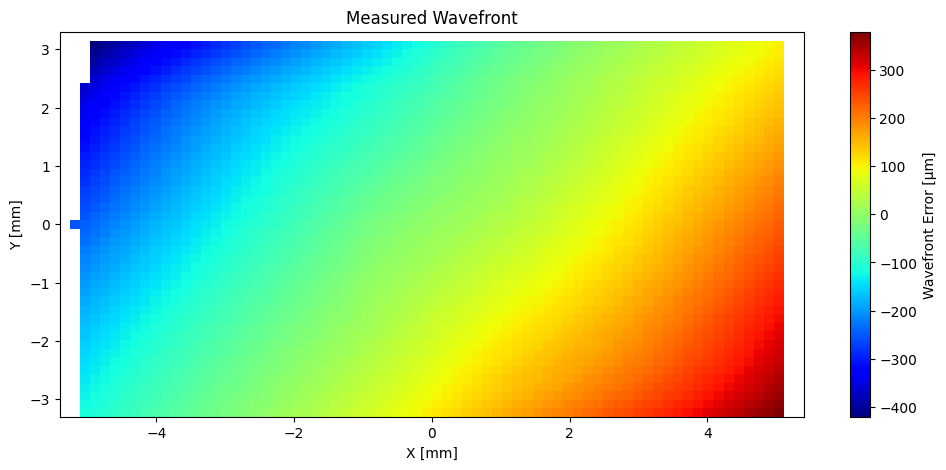

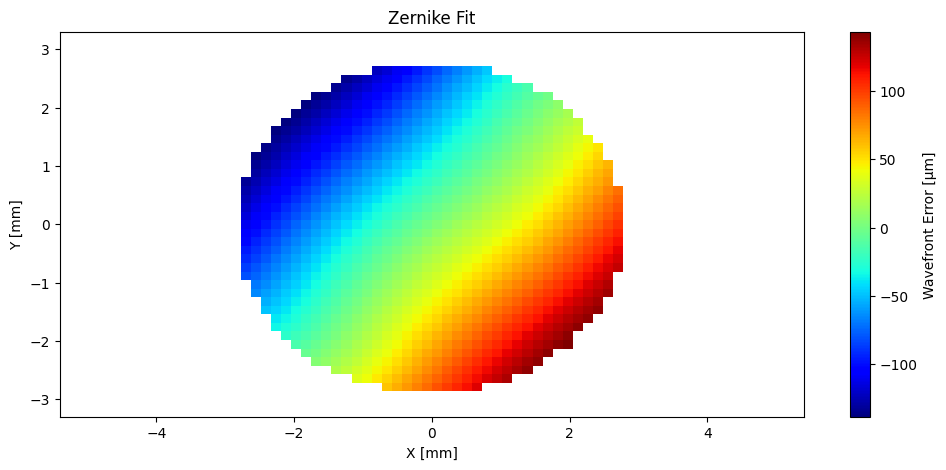

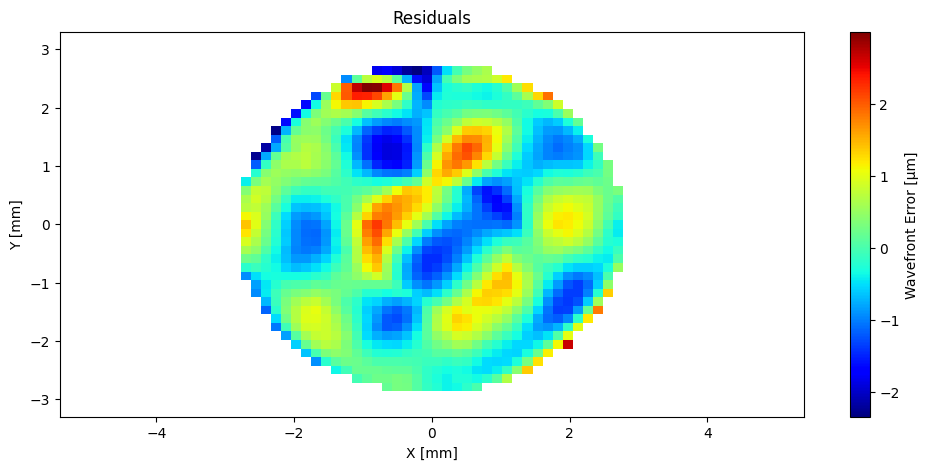

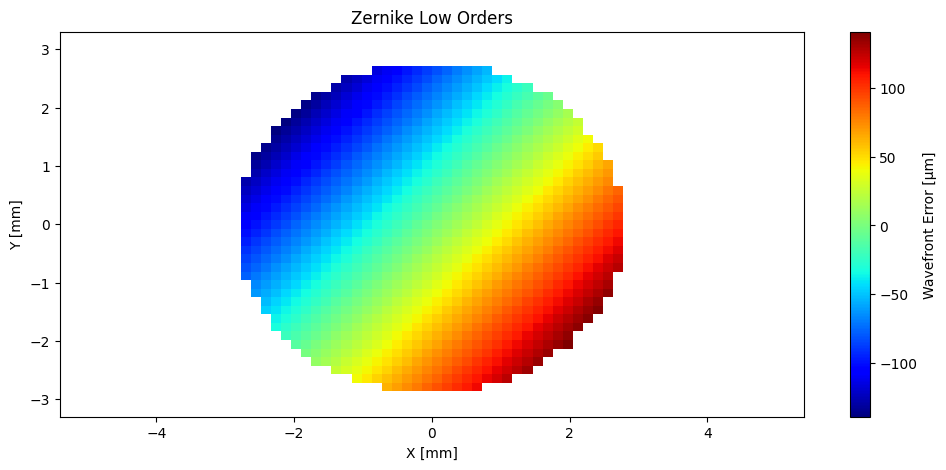

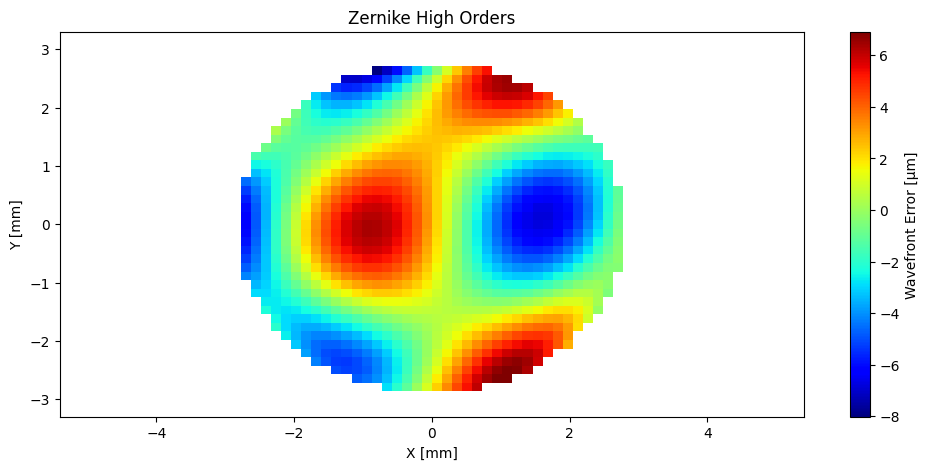

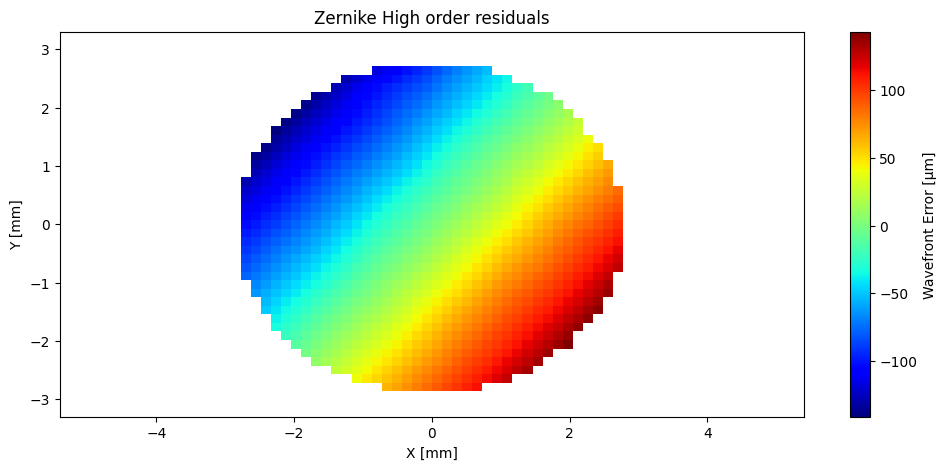

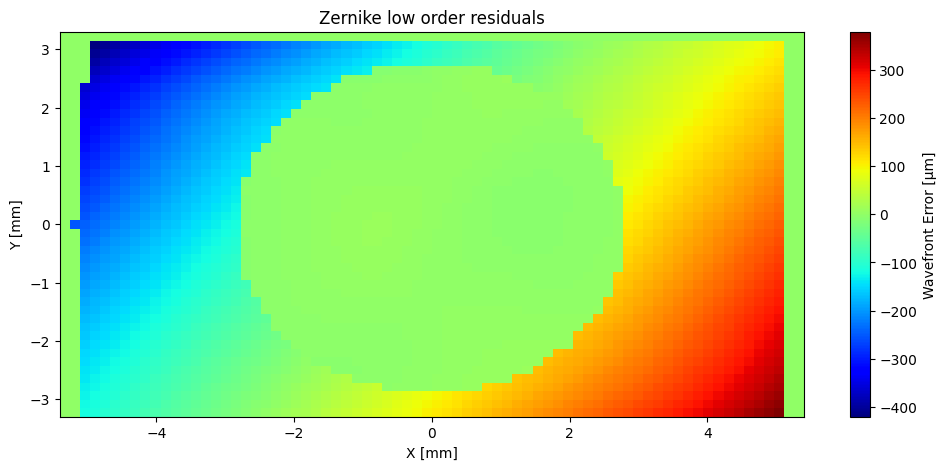

In [5]:

files = [f for f in os.listdir(directory) if f.endswith('.csv')]
if not files:
    raise FileNotFoundError("No CSV files found in directory")
filename = files[filenumber]
full_path = os.path.join(directory, filename)
file = full_path  

##### Lettura dati ##############################################################
x_coords, y_coords, wavefront_data = parse_wavefront_grid(file)
pupil_diameter, pupil_center_x, pupil_center_y = parse_pupil_diameter_center(file)
#######################################################################################
######## costruzione griglia  ##################################à
#orders =  15 # 7 ideale
#n_modes = (orders + 1) * (orders + 2) // 2
X_norm = (x_coords-pupil_center_x) / (pupil_diameter / 2)
Y_norm = (y_coords-pupil_center_y) / (pupil_diameter / 2)
X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
R = np.sqrt(X_mesh**2 + Y_mesh**2)
Theta = np.arctan2(Y_mesh, X_mesh)
mask = R <= 1
#########################################################################
# Create Zernike basis 
basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
#fit the wavefront with Zernike basis
Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wavefront_data[mask], rcond=None)
# Create fitted wavefront
wavefront_fit = np.full_like(wavefront_data, np.nan)
fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
wavefront_fit[mask] = fit_vals
residuals = wavefront_data - wavefront_fit
########################################################################################
#for i, c in enumerate(coeffs, 1):
#    print(f"Mode {i}: {c:.6f} ")#µm"
#################### FIT TOTALE E SOTTRAZIONE PRIMI TERMINI #############
#basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
#Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
#coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wavefront_data[mask], rcond=None)
#wf_total = sum(coeffs[j] * basis_stack[j] for j in range(n_modes))
wf_low = sum(coeffs[j] * basis_stack[j] for j in range(3))  # cambiare quello ignora gradualmente più fattori 
wf_high = wavefront_fit - wf_low
residuals_low = wavefront_data - wf_low
residuals_high = wavefront_data - wf_high

#####################   grafici  ####################################################
# Plot measured wavefront
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wavefront_data, title='Measured Wavefront')
# Plot Zernike
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wavefront_fit, title='Zernike Fit')
#residuals
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], residuals, title='Residuals')
#wavefront_fit = np.nan_to_num(wavefront_fit, nan=0.0)
#print(wavefront_fit.shape)
#residuals = np.nan_to_num(wavefront_data - wavefront_fit, nan=0.0)
#plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], residuals, title='Zernike fit residuals')

plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wf_low, title='Zernike Low Orders')
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wf_high, title='Zernike High Orders')
wf_total = np.nan_to_num(wavefront_fit, nan=0.0)
wf_high= np.nan_to_num(wf_high, nan=0.0)
wf_low = np.nan_to_num(wf_low, nan=0.0)
residuals_low = np.nan_to_num(wavefront_data - wf_low, nan=0.0)   # residui dovuti ai termini id basso ordine
residual_high = np.nan_to_num(wavefront_data - wf_high, nan=0.0)  # residui dei temini di alto ordine
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], residuals_high, title='Zernike High order residuals')
plot_wavefront_residuals(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wavefront_data, wf_low, title='Zernike low order residuals')



<span style="color:Green; font-size: 2.5em;">Beta </span>

In [43]:
from astropy.table import Table
import pandas as pd


def build_dataframe(results_all):
    records = []
    for res in results_all:
        rec = {
            'filename': os.path.basename(res['filename']),
            'rms_wfe': res['rms_wfe'],
            'pv_wfe': res['pv_wfe']
        }
        coeffs = res['coeffs']

        for i, c in enumerate(coeffs):
            rec[f'coeff_{i+1}'] = c
        records.append(rec)
    df = pd.DataFrame.from_records(records)
    return df

def save_metrics_as_fits(df, out_fits):
    t = Table.from_pandas(df)
    hdu_table = fits.BinTableHDU(data=t, name='METRICS')
    primary = fits.PrimaryHDU()
    primary.header['COMMENT'] = "Zernike WFE analysis metrics"
    hdul = fits.HDUList([primary, hdu_table])
    hdul.writeto(out_fits, overwrite=True)
    print(f"Tabella FITS salvata in {out_fits}")

def save_wavefront_cube(wf_list, filenames, out_fits, extname_prefix):
    """
    wf_list: lista di 2D array (Ny,Nx), N_file
    """
    shape0 = wf_list[0].shape
    for arr in wf_list:
        if arr.shape != shape0:
            raise ValueError("Shape diversa tra wavefront")
    cube = np.stack(wf_list, axis=0).astype(np.float32)  # (N,Ny,Nx)
 
    hdu_primary = fits.PrimaryHDU(data=cube)
    hdu_primary.header['COMMENT'] = f"Cube {extname_prefix}: dim (N_files, Ny, Nx)"

    indices = np.arange(len(filenames), dtype=np.int32)
    maxlen = max(len(fn) for fn in filenames)
    col_idx = fits.Column(name='index', format='K', array=indices)
    col_fn  = fits.Column(name='filename', format=f'A{maxlen}', array=np.array(filenames, dtype=f'U{maxlen}'))
    table_hdu = fits.BinTableHDU.from_columns([col_idx, col_fn], name=f'{extname_prefix}_FILES')
    hdul = fits.HDUList([hdu_primary, table_hdu])
    hdul.writeto(out_fits, overwrite=True)
    hdul.close()
    #print(f"Saved cube {extname_prefix} in: {out_fits}")

def data_loading(file):
    #match = re.search(r'elev(\d{2})', file)
    #if match:
    #    elevation = int(match.group(1))
    #    print(f"Elevation extracted: {elevation}")
    #else:
    #    raise ValueError(f"Elevation not found in file name: {file}")
    x_coords, y_coords, wavefront_data = parse_wavefront_grid(file)
    pupil_diameter, pupil_center_x, pupil_center_y = parse_pupil_diameter_center(file)
    return x_coords, y_coords, wavefront_data, pupil_diameter, pupil_center_x, pupil_center_y  #, elevation

def zernike_wfe_analysis(file,n_modes,exclude_low):
    results_single_file=[]
#C'ERA ELEVATION ANCHE
    x_coords, y_coords, wavefront_data, pupil_diameter, pupil_center_x, pupil_center_y = data_loading(file)
    # griglia
    X_norm = (x_coords-pupil_center_x) / (pupil_diameter / 2)
    Y_norm = (y_coords-pupil_center_y) / (pupil_diameter / 2)
    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)
    mask = R <= 1
    # Zernike basis 
    basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
    # fit coefficienti
    Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
    coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wavefront_data[mask], rcond=None)
    # fitted wavefront
    #wavefront_total = np.full_like(wavefront_data, np.nan)
    wavefront_total = np.zeros_like(wavefront_data)
    fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
    wavefront_total[mask] = fit_vals
    ########################################################################################
    #for i, c in enumerate(coeffs, 0):
    #    print(f"Mode {i}: {c:.6f} ")#µm"
    #SOTTRAZIONE PRIMI TERMINI #############
    wf_low = np.zeros_like(wavefront_data)
    for j in range(exclude_low):
        wf_low[mask] += coeffs[j] * basis_stack[j][mask]
    wf_high = wavefront_total - wf_low

    # risultati
    residuals_total = wavefront_data - wavefront_total
    residuals_low = wavefront_data - wf_low
    residuals_high = wavefront_data - wf_high
    rms_wfe = np.sqrt(np.nanmean(residuals_high**2))
    pv_wfe = np.nanmax(residuals_high) - np.nanmin(residuals_high)
    
    results_single_file = {
        'filename': file,
        'rms_wfe': rms_wfe,
        'pv_wfe': pv_wfe,
        'coeffs': coeffs,
        'residuals_total': residuals_total,
        'residuals_low': residuals_low,
        'residuals_high': residuals_high,
        'wavefront_total': wavefront_total,
        'wavefront_low': wf_low,
        'wavefront_high': wf_high
    }
    return [results_single_file]


########################## MAIN ##########################################################
files = [f for f in os.listdir(directory) if f.endswith('.csv')]
print(f"Found {len(files)} files in the folder")
if not files:
    raise FileNotFoundError("No CSV files found in directory")

exclude_low = 3  # Number of Zernike modes to exclude

results_all = []
wf_total_list = []
wf_low_list = []
wf_high_list = []
res_total_list = []
res_low_list = []
res_high_list = []
filenames = []

for filenumber in range(len(files)):
    results_single_file = []
    filename = files[filenumber]
    full_path = os.path.join(directory, filename)
    file = full_path
    print(f"Processing {full_path}...")
    try:
        results_single_file = zernike_wfe_analysis(full_path, n_modes, exclude_low)
    except Exception as e:
        print(f"  Skip {file}: {e}")
        continue
     # results_single_file è lista con un dict
    res = results_single_file[0]
    results_all.append(res)
    filenames.append(os.path.basename(res['filename']))
    wf_total_list.append(res['wavefront_total'])
    wf_low_list.append(res['wavefront_low'])
    wf_high_list.append(res['wavefront_high'])
    res_total_list.append(res['residuals_total'])
    res_low_list.append(res['residuals_low'])
    res_high_list.append(res['residuals_high'])

os.makedirs('results', exist_ok=True)
  
df = build_dataframe(results_all)
csv_out = os.path.join('results', 'wfe_all_results.csv')
df.to_csv(csv_out, index=False)
print(f"CSV salvato in: {csv_out}")
fits_out = os.path.join('results', 'wfe_all_results.fits')
save_metrics_as_fits(df, fits_out)  

save_wavefront_cube(wf_total_list, filenames, os.path.join('results','wavefront_total_cube.fits'), 'WFTOTAL')
save_wavefront_cube(wf_low_list,   filenames, os.path.join('results','wavefront_low_cube.fits'),   'WFLOW')
save_wavefront_cube(wf_high_list,  filenames, os.path.join('results','wavefront_high_cube.fits'),  'WFHIGH')
save_wavefront_cube(res_total_list, filenames, os.path.join('results','residuals_total_cube.fits'), 'RSTOTAL')
save_wavefront_cube(res_low_list,   filenames, os.path.join('results','residuals_low_cube.fits'),   'RSLOW')
save_wavefront_cube(res_high_list,  filenames, os.path.join('results','residuals_high_cube.fits'),  'RSHIGH')
  





Found 20 files in the folder
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\1.csv...
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\10.csv...
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\11.csv...
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\12.csv...
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\13.csv...
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\14.csv...
Processing C:\Users\buon

In [12]:
df

,filename,rms_wfe,pv_wfe,coeff_1,coeff_2,coeff_3,coeff_4,coeff_5,coeff_6,coeff_7,...,coeff_18,coeff_19,coeff_20,coeff_21,coeff_22,coeff_23,coeff_24,coeff_25,coeff_26,coeff_27
0,1.csv,144.374516,790.484,0.372331,52.792398,-45.703226,-0.797274,-0.167480,-0.818911,-0.466322,...,0.477873,0.374285,0.717100,-0.193312,-0.168591,0.064590,0.038776,-0.006050,-0.009334,0.098245
1,10.csv,147.431191,807.940,0.044521,54.270357,-45.469497,-1.104184,-0.062145,-0.949264,-0.526190,...,0.499928,0.449057,1.006980,-0.363356,-0.176503,0.111599,0.064768,0.003046,-0.036983,0.168734
2,11.csv,144.071482,777.564,0.606144,53.003322,-44.974660,-0.636950,-0.265808,-1.244496,-0.189169,...,0.561522,0.237390,0.751289,-0.086357,-0.130901,0.050348,-0.012791,0.028181,0.033606,0.024707
3,12.csv,144.191816,792.551,0.230836,52.926535,-45.388763,-0.929325,-0.135326,-1.172921,-0.384361,...,0.452964,0.355692,0.762695,-0.219599,-0.143169,0.069436,0.064395,-0.038131,0.003943,0.228970
4,13.csv,144.410908,788.424,0.414211,53.181157,-45.121430,-0.728429,-0.375563,-1.212194,-0.159927,...,0.490828,0.212445,0.631397,-0.023755,-0.114276,0.040966,-0.019431,0.054646,0.035199,0.012596
5,14.csv,146.268156,791.216,0.732663,54.012819,-44.851646,-0.644186,-0.150275,-1.157560,-0.312178,...,0.582997,0.272743,0.790304,-0.250713,-0.103641,0.073972,-0.014509,0.093100,0.045011,0.045965
6,15.csv,148.118074,815.205,-0.280725,54.628484,-45.342754,-1.449106,-0.312686,-0.526598,-0.601796,...,0.409198,0.487474,1.150689,-0.385615,-0.163679,0.167579,0.073571,-0.123790,-0.027173,0.280917
7,16.csv,147.393760,804.953,0.076287,54.459370,-45.509462,-1.112858,-0.185833,-0.684483,-0.579380,...,0.560688,0.498432,0.971468,-0.369602,-0.190594,0.114060,0.056385,0.006435,-0.132632,0.036096
8,17.csv,148.428859,814.201,0.229252,54.375490,-45.768464,-1.068787,-0.141643,-0.538339,-0.756501,...,0.519722,0.517706,0.876282,-0.382976,-0.217882,0.114569,0.062172,0.001313,-0.035595,0.090309
9,18.csv,147.085252,800.396,0.356144,54.442078,-44.909534,-0.853363,-0.412339,-1.102918,-0.281173,...,0.519082,0.354837,0.888160,-0.190095,-0.154704,0.121480,0.020331,0.014531,-0.014388,0.146538


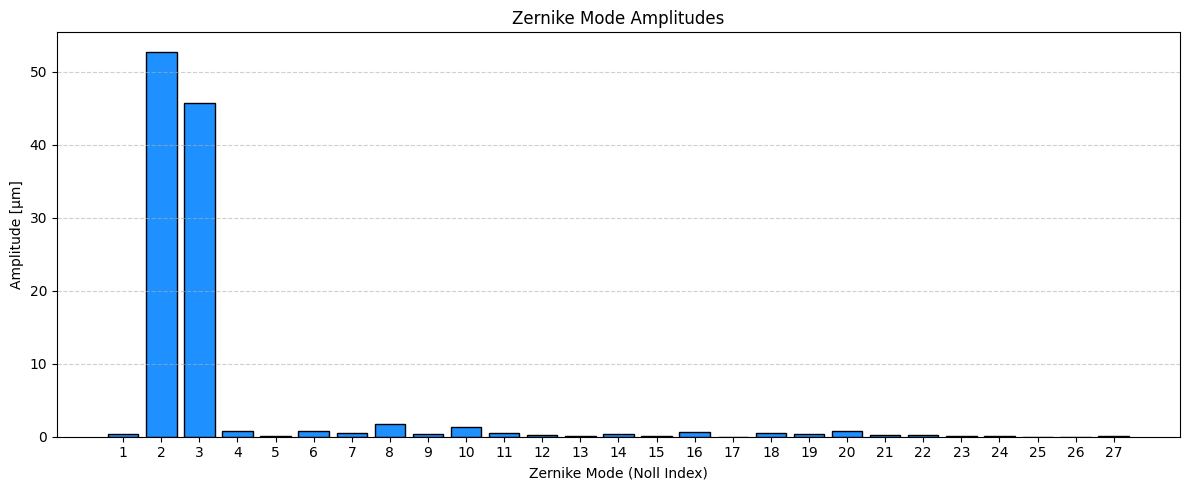

In [ ]:


def plot_zernike_amplitudes(coeffs):
    coeffs = np.array(coeffs)
    n_modes = len(coeffs)
    noll_indices = np.arange(1, n_modes + 1)  # Noll indexing starts at 1

    amplitudes = np.abs(coeffs)  # valore assoluto in micron

    plt.figure(figsize=(12, 5))
    plt.bar(noll_indices, amplitudes, color='dodgerblue', edgecolor='black')
    plt.xlabel("Zernike Mode (Noll Index)")
    plt.ylabel("Amplitude [μm]")
    plt.title("Zernike Mode Amplitudes")
    plt.xticks(noll_indices)
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    
coeffs = results_all[0]['coeffs']  
plot_zernike_amplitudes(coeffs)



<span style="color:Yellow; font-size: 2.5em;">Delta </span>

In [ ]:
from astropy.table import Table

def build_dataframe(results_all, coeffs_mean = None):
    records = []
    for res in results_all:
        rec = {
            'filename': os.path.basename(res['filename']),
            'rms_wfe': res['rms_wfe'],
            'pv_wfe': res['pv_wfe']
        }
        coeffs = res['coeffs']

        for i, c in enumerate(coeffs):
            rec[f'coeff_{i+1}'] = c
        records.append(rec)
    if coeffs_mean is not None:
        rec_mean = {'filename': 'MEAN_WAVEFRONT', 'rms_wfe': np.nan, 'pv_wfe': np.nan}
        for i, c in enumerate(coeffs_mean):
            rec_mean[f'coeff_{i + 1}'] = c 
        records.append(rec_mean)
        
    df = pd.DataFrame.from_records(records)
    return df

def save_metrics_as_fits(df, out_fits):
    t = Table.from_pandas(df)
    hdu_table = fits.BinTableHDU(data=t, name='METRICS')
    primary = fits.PrimaryHDU()
    primary.header['COMMENT'] = "Zernike WFE analysis metrics"
    hdul = fits.HDUList([primary, hdu_table])
    hdul.writeto(out_fits, overwrite=True)
    print(f"Tabella FITS salvata in {out_fits}")

def save_wavefront_cube(wf_list, filenames, out_fits, extname_prefix):
    """
    wf_list: lista di 2D array (Ny,Nx), N_file
    """
    shape0 = wf_list[0].shape
    for arr in wf_list:
        if arr.shape != shape0:
            raise ValueError("Shape diversa tra wavefront")
    cube = np.stack(wf_list, axis=0).astype(np.float32)  # (N,Ny,Nx)
 
    hdu_primary = fits.PrimaryHDU(data=cube)
    hdu_primary.header['COMMENT'] = f"Cube {extname_prefix}: dim (N_files, Ny, Nx)"

    indices = np.arange(len(filenames), dtype=np.int32)
    maxlen = max(len(fn) for fn in filenames)
    col_idx = fits.Column(name='index', format='K', array=indices)
    col_fn  = fits.Column(name='filename', format=f'A{maxlen}', array=np.array(filenames, dtype=f'U{maxlen}'))
    table_hdu = fits.BinTableHDU.from_columns([col_idx, col_fn], name=f'{extname_prefix}_FILES')
    hdul = fits.HDUList([hdu_primary, table_hdu])
    hdul.writeto(out_fits, overwrite=True)
    hdul.close()
    print(f"Saved cube {extname_prefix} in: {out_fits}")

def data_loading(file):
    #match = re.search(r'elev(\d{2})', file)
    #if match:
    #    elevation = int(match.group(1))
    #    print(f"Elevation extracted: {elevation}")
    #else:
    #    raise ValueError(f"Elevation not found in file name: {file}")
    x_coords, y_coords, wavefront_data = parse_wavefront_grid(file)
    pupil_diameter, pupil_center_x, pupil_center_y = parse_pupil_diameter_center(file)
    return x_coords, y_coords, wavefront_data, pupil_diameter, pupil_center_x, pupil_center_y  #, elevation

def zernike_wfe_analysis(file,n_modes,exclude_low):
    results_single_file=[]
#C'ERA ELEVATION ANCHE
    x_coords, y_coords, wavefront_data, pupil_diameter, pupil_center_x, pupil_center_y = data_loading(file)
    # griglia
    X_norm = (x_coords-pupil_center_x) / (pupil_diameter / 2)
    Y_norm = (y_coords-pupil_center_y) / (pupil_diameter / 2)
    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)
    mask = R <= 1
    # Zernike basis 
    basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
    # fit coefficienti
    Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
    coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wavefront_data[mask], rcond=None)
    # fitted wavefront
    #wavefront_total = np.full_like(wavefront_data, np.nan)
    wavefront_total = np.zeros_like(wavefront_data)
    fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
    wavefront_total[mask] = fit_vals
    ########################################################################################
    #for i, c in enumerate(coeffs, 0):
    #    print(f"Mode {i}: {c:.6f} ")#µm"
    #SOTTRAZIONE PRIMI TERMINI #############
    wf_low = np.zeros_like(wavefront_data)
    for j in range(exclude_low):
        wf_low[mask] += coeffs[j] * basis_stack[j][mask]
    wf_high = wavefront_total - wf_low

    # risultati
    residuals_total = wavefront_data - wavefront_total
    residuals_low = wavefront_data - wf_low
    residuals_high = wavefront_data - wf_high
    rms_wfe = np.sqrt(np.nanmean(residuals_high**2))
    pv_wfe = np.nanmax(residuals_high) - np.nanmin(residuals_high)
    
    results_single_file = {
        'filename': file,
        'rms_wfe': rms_wfe,
        'pv_wfe': pv_wfe,
        'coeffs': coeffs,
        'residuals_total': residuals_total,
        'residuals_low': residuals_low,
        'residuals_high': residuals_high,
        'wavefront_total': wavefront_total,
        'wavefront_low': wf_low,
        'wavefront_high': wf_high,
        'wavefront_measured': wavefront_data
    }
    return [results_single_file]


########################## MAIN ##########################################################
files = [f for f in os.listdir(directory) if f.endswith('.csv')]
print(f"Found {len(files)} files in the folder")
if not files:
    raise FileNotFoundError("No CSV files found in directory")

exclude_low = 3  # Number of Zernike modes to exclude

results_all = []
wf_total_list = []
wf_low_list = []
wf_high_list = []
res_total_list = []
res_low_list = []
res_high_list = []
filenames = []
wf_measured_all=[]
first_file = True

for filenumber in range(len(files)):
    results_single_file = []
    filename = files[filenumber]
    full_path = os.path.join(directory, filename)
    file = full_path
    print(f"Processing {full_path}...")
    try:
        results_single_file = zernike_wfe_analysis(full_path, n_modes, exclude_low)
    except Exception as e:
        print(f"  Skip {file}: {e}")
        continue
    
   
    
     # results_single_file è lista con un dict
    res = results_single_file[0]
    results_all.append(res)
    filenames.append(os.path.basename(res['filename']))
    wf_measured_all.append(res['wavefront_measured'])
    wf_total_list.append(res['wavefront_total'])
    wf_low_list.append(res['wavefront_low'])
    wf_high_list.append(res['wavefront_high'])
    res_total_list.append(res['residuals_total'])
    res_low_list.append(res['residuals_low'])
    res_high_list.append(res['residuals_high'])
    
    
#########################################
###  wavefront medio + fit
wf_measured_stack = np.stack(wf_measured_all, axis=0)
wf_measured_mean = np.nanmean(wf_measured_stack, axis=0)
# Load a reference file to get pupil parameters
ref_file = os.path.join(directory, files[0])
x_coords, y_coords, _, pupil_diameter, pupil_center_x, pupil_center_y = data_loading(ref_file)
X_norm = (x_coords - pupil_center_x) / (pupil_diameter / 2)
Y_norm = (y_coords - pupil_center_y) / (pupil_diameter / 2)
X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
R = np.sqrt(X_mesh**2 + Y_mesh**2)
Theta = np.arctan2(Y_mesh, X_mesh)
mask = R <= 1
basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
coeffs_wf_mean, _, _, _ = np.linalg.lstsq(Z_mat, wf_measured_mean[mask], rcond=None)
wavefront_mean_fit = np.zeros_like(wf_measured_mean)
fit_vals = np.sum([coeffs_wf_mean[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
wavefront_mean_fit[mask] = fit_vals



os.makedirs('results', exist_ok=True)
df = build_dataframe(results_all, coeffs_wf_mean)
csv_out = os.path.join('results', 'wfe_all_results.csv')
df.to_csv(csv_out, index=False)
print(f"CSV salvato in: {csv_out}")
fits_out = os.path.join('results', 'wfe_all_results.fits')
save_metrics_as_fits(df, fits_out)  

save_wavefront_cube([wf_measured_mean], ['mean_wavefront_measured'], os.path.join('results', 'wavefront_measured_mean.fits'), 'WFMEAN')
save_wavefront_cube(wf_measured_all, filenames, os.path.join('results', 'wavefront_measured_cube.fits'), 'WFMEAS')
save_wavefront_cube(wf_total_list, filenames, os.path.join('results','wavefront_total_cube.fits'), 'WFTOTAL')
save_wavefront_cube(wf_low_list,   filenames, os.path.join('results','wavefront_low_cube.fits'),   'WFLOW')
save_wavefront_cube(wf_high_list,  filenames, os.path.join('results','wavefront_high_cube.fits'),  'WFHIGH')
save_wavefront_cube(res_total_list, filenames, os.path.join('results','residuals_total_cube.fits'), 'RSTOTAL')
save_wavefront_cube(res_low_list,   filenames, os.path.join('results','residuals_low_cube.fits'),   'RSLOW')
save_wavefront_cube(res_high_list,  filenames, os.path.join('results','residuals_high_cube.fits'),  'RSHIGH')
  
#musichetta(song_jojo)

Found 20 files in the folder
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\1.csv...
x_coords length: 74
wavefront_data shape: (45, 74)
Pupil diameter: 5.8 mm, Center: (0.05, -0.056) mm
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\10.csv...
x_coords length: 74
wavefront_data shape: (45, 74)
Pupil diameter: 5.8 mm, Center: (0.05, -0.056) mm
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\11.csv...
x_coords length: 74
wavefront_data shape: (45, 74)
Pupil diameter: 5.8 mm, Center: (0.05, -0.056) mm
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\12.csv...
x_coords length: 74
wavefront_data sh

C:\Users\buonc\AppData\Local\Temp\ipykernel_39576\4078493506.py:170: RuntimeWarning: Mean of empty slice
  wf_measured_mean = np.nanmean(wf_measured_stack, axis=0)


<span style="color:Yellow; font-size: 2.5em;">Delta - Lettura degli output </span>

x_coords length: 74
wavefront_data shape: (45, 74)
Pupil diameter: 5.8 mm, Center: (0.05, -0.056) mm
Slice 15 caricata da 5.csv


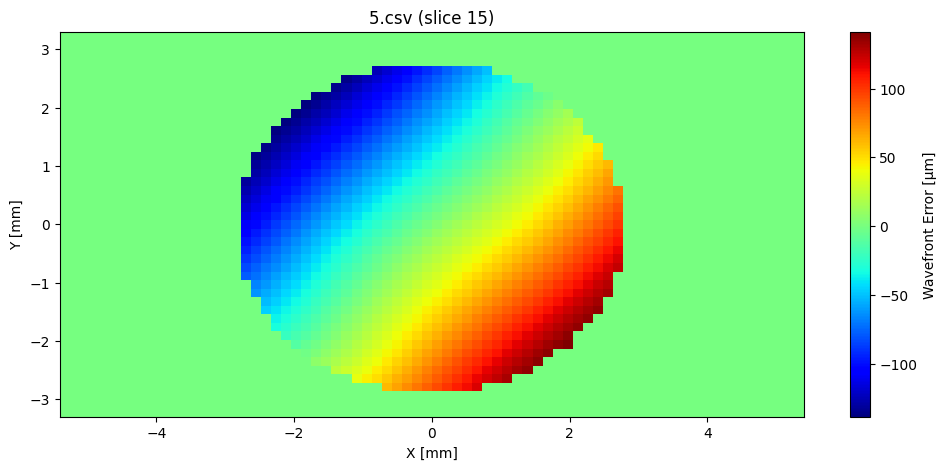

In [35]:
def read_wavefront_cube(cube_path, csv_directory, slice_idx, data_loading_fn):
    """
    Legge un FITS cube di wavefront e restituisce:
      x_coords, y_coords: vettori di coordinate in mm
      wf_data: array 2D del wavefront (slice slice_idx)
      filename: nome del CSV originale corrispondente

    Parametri:
      cube_path        : percorso al FITS cube (es. 'results/wavefront_total_cube.fits')
      csv_directory    : cartella contenente i CSV originali
      slice_idx        : indice della slice da estrarre (0-based)
      data_loading_fn  : funzione data_loading(file) → x,y,wf,... 

    Ritorna:
      x_coords, y_coords, wf_data, filename
    """
    # Apri il FITS cube
    hdul = fits.open(cube_path)
    cube = hdul[0].data               # shape = (N_slices, Ny, Nx)
    # TAB: la seconda HDU è la tabella index↔filename
    tbl  = hdul[1].data
    hdul.close()

    # Estrai nome file e slice
    filename = tbl['filename'][slice_idx].strip()
    wf_data  = cube[slice_idx]

    # Ricava x,y dal CSV corrispondente
    csv_path = os.path.join(csv_directory, filename)
    x_coords, y_coords, _, _, _, _ = data_loading_fn(csv_path)

    return x_coords, y_coords, wf_data, filename




cube_path     = 'results/wavefront_total_cube.fits'
csv_directory = directory  
slice_idx     = 15          

x, y, wf, fn = read_wavefront_cube(
    cube_path,
    csv_directory,
    slice_idx,
    data_loading 
)


print("Slice", slice_idx, "caricata da", fn)
plot_wavefront_new(x, y, wf, title=f"{fn} (slice {slice_idx})")




x_coords length: 74
wavefront_data shape: (45, 74)
Pupil diameter: 5.8 mm, Center: (0.05, -0.056) mm


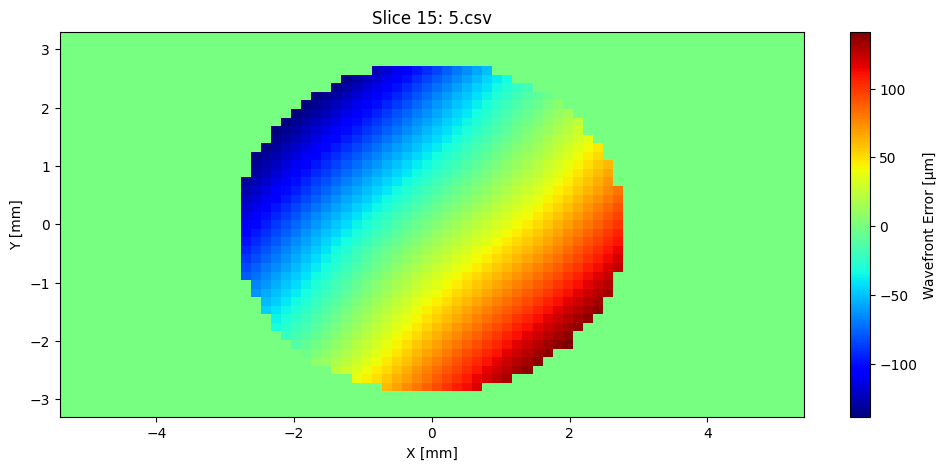

In [34]:

cube_path = 'results/wavefront_total_cube.fits'

with fits.open(cube_path) as hdul:
    cube = hdul[0].data
    tbl  = hdul['WFTOTAL_FILES'].data
    df_index = pd.DataFrame({
        'index':    tbl['index'],
        'filename': tbl['filename']
    })

# indice della slice da mostrare
slice_idx = 15
slice_data = cube[slice_idx]

# Recupera x_coords, y_coords in mm dal file
fn = df_index.loc[slice_idx, 'filename']
path = os.path.join(directory, fn)
x_coords, y_coords, _, _, _, _ = data_loading(path)


plot_wavefront_new(x_coords, y_coords, slice_data, title=f"Slice {slice_idx}: {fn}")

In [19]:
df

,filename,rms_wfe,pv_wfe,coeff_1,coeff_2,coeff_3,coeff_4,coeff_5,coeff_6,coeff_7,...,coeff_18,coeff_19,coeff_20,coeff_21,coeff_22,coeff_23,coeff_24,coeff_25,coeff_26,coeff_27
0,1.csv,144.374516,790.484,0.372331,52.792398,-45.703226,-0.797274,-0.167480,-0.818911,-0.466322,...,0.477873,0.374285,0.717100,-0.193312,-0.168591,0.064590,0.038776,-0.006050,-0.009334,0.098245
1,10.csv,147.431191,807.940,0.044521,54.270357,-45.469497,-1.104184,-0.062145,-0.949264,-0.526190,...,0.499928,0.449057,1.006980,-0.363356,-0.176503,0.111599,0.064768,0.003046,-0.036983,0.168734
2,11.csv,144.071482,777.564,0.606144,53.003322,-44.974660,-0.636950,-0.265808,-1.244496,-0.189169,...,0.561522,0.237390,0.751289,-0.086357,-0.130901,0.050348,-0.012791,0.028181,0.033606,0.024707
3,12.csv,144.191816,792.551,0.230836,52.926535,-45.388763,-0.929325,-0.135326,-1.172921,-0.384361,...,0.452964,0.355692,0.762695,-0.219599,-0.143169,0.069436,0.064395,-0.038131,0.003943,0.228970
4,13.csv,144.410908,788.424,0.414211,53.181157,-45.121430,-0.728429,-0.375563,-1.212194,-0.159927,...,0.490828,0.212445,0.631397,-0.023755,-0.114276,0.040966,-0.019431,0.054646,0.035199,0.012596
5,14.csv,146.268156,791.216,0.732663,54.012819,-44.851646,-0.644186,-0.150275,-1.157560,-0.312178,...,0.582997,0.272743,0.790304,-0.250713,-0.103641,0.073972,-0.014509,0.093100,0.045011,0.045965
6,15.csv,148.118074,815.205,-0.280725,54.628484,-45.342754,-1.449106,-0.312686,-0.526598,-0.601796,...,0.409198,0.487474,1.150689,-0.385615,-0.163679,0.167579,0.073571,-0.123790,-0.027173,0.280917
7,16.csv,147.393760,804.953,0.076287,54.459370,-45.509462,-1.112858,-0.185833,-0.684483,-0.579380,...,0.560688,0.498432,0.971468,-0.369602,-0.190594,0.114060,0.056385,0.006435,-0.132632,0.036096
8,17.csv,148.428859,814.201,0.229252,54.375490,-45.768464,-1.068787,-0.141643,-0.538339,-0.756501,...,0.519722,0.517706,0.876282,-0.382976,-0.217882,0.114569,0.062172,0.001313,-0.035595,0.090309
9,18.csv,147.085252,800.396,0.356144,54.442078,-44.909534,-0.853363,-0.412339,-1.102918,-0.281173,...,0.519082,0.354837,0.888160,-0.190095,-0.154704,0.121480,0.020331,0.014531,-0.014388,0.146538


<span style="color:Yellow; font-size: 2.5em;">Delta - Solo WF Medio </span>

Found 20 files in the folder
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\1.csv...
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\10.csv...
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\11.csv...
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\12.csv...
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\13.csv...
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\14.csv...
Processing C:\Users\buon

C:\Users\buonc\AppData\Local\Temp\ipykernel_17980\2674339870.py:142: RuntimeWarning: Mean of empty slice
  wf_measured_mean = np.nanmean(wf_measured_stack, axis=0)


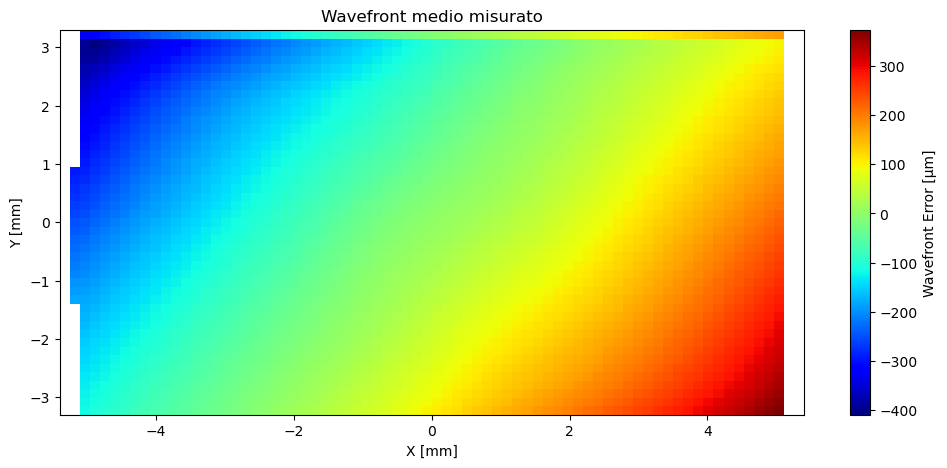

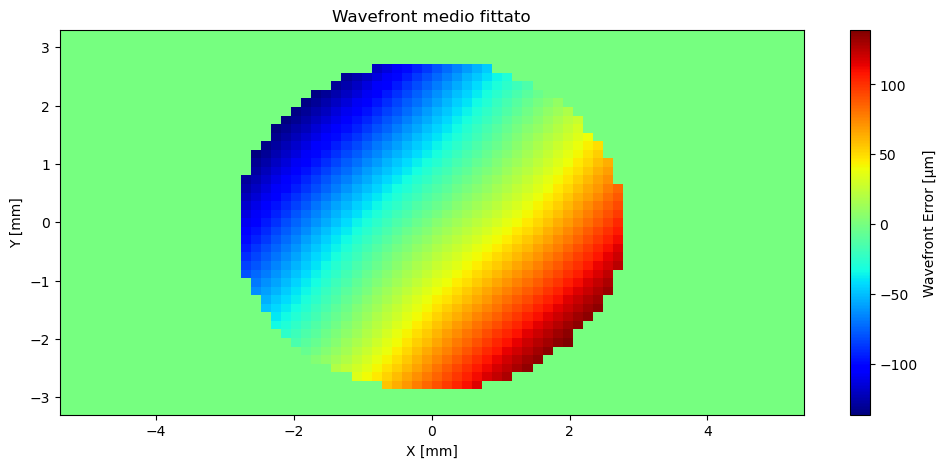

Coefficienti Zernike medi:
Z1: 0.239983
Z2: 53.688661
Z3: -43.444852
Z4: -0.873576
Z5: -0.196548
Z6: -1.004251
Z7: -0.362619
Z8: 1.957630
Z9: -0.124460
Z10: -1.486986
Z11: 0.443581
Z12: 0.347653
Z13: 0.075850
Z14: -0.313586
Z15: -0.133372
Z16: -0.764928
Z17: -0.017493
Z18: 0.522227
Z19: 0.346929
Z20: 0.814096
Z21: -0.201931
Z22: -0.151397
Z23: 0.074666
Z24: 0.020164
Z25: 0.018429
Z26: 0.002414
Z27: 0.083941


In [51]:
def build_dataframe(results_all, coeffs_mean = None):
    records = []
    for res in results_all:
        rec = {
            'filename': os.path.basename(res['filename']),
            'rms_wfe': res['rms_wfe'],
            'pv_wfe': res['pv_wfe']
        }
        coeffs = res['coeffs']

        for i, c in enumerate(coeffs):
            rec[f'coeff_{i+1}'] = c
        records.append(rec)
    if coeffs_mean is not None:
        rec_mean = {'filename': 'MEAN_WAVEFRONT', 'rms_wfe': np.nan, 'pv_wfe': np.nan}
        for i, c in enumerate(coeffs_mean):
            rec_mean[f'coeff_{i + 1}'] = c 
        records.append(rec_mean)
        
    df = pd.DataFrame.from_records(records)
    return df

def save_metrics_as_fits(df, out_fits):
    t = Table.from_pandas(df)
    hdu_table = fits.BinTableHDU(data=t, name='METRICS')
    primary = fits.PrimaryHDU()
    primary.header['COMMENT'] = "Zernike WFE analysis metrics"
    hdul = fits.HDUList([primary, hdu_table])
    hdul.writeto(out_fits, overwrite=True)
    print(f"Tabella FITS salvata in {out_fits}")

def save_wavefront_cube(wf_list, filenames, out_fits, extname_prefix):
    """
    wf_list: lista di 2D array (Ny,Nx), N_file
    """
    shape0 = wf_list[0].shape
    for arr in wf_list:
        if arr.shape != shape0:
            raise ValueError("Shape diversa tra wavefront")
    cube = np.stack(wf_list, axis=0).astype(np.float32)  # (N,Ny,Nx)
 
    hdu_primary = fits.PrimaryHDU(data=cube)
    hdu_primary.header['COMMENT'] = f"Cube {extname_prefix}: dim (N_files, Ny, Nx)"

    indices = np.arange(len(filenames), dtype=np.int32)
    maxlen = max(len(fn) for fn in filenames)
    col_idx = fits.Column(name='index', format='K', array=indices)
    col_fn  = fits.Column(name='filename', format=f'A{maxlen}', array=np.array(filenames, dtype=f'U{maxlen}'))
    table_hdu = fits.BinTableHDU.from_columns([col_idx, col_fn], name=f'{extname_prefix}_FILES')
    hdul = fits.HDUList([hdu_primary, table_hdu])
    hdul.writeto(out_fits, overwrite=True)
    hdul.close()
    print(f"Saved cube {extname_prefix} in: {out_fits}")

def data_loading(file):
    #match = re.search(r'elev(\d{2})', file)
    #if match:
    #    elevation = int(match.group(1))
    #    print(f"Elevation extracted: {elevation}")
    #else:
    #    raise ValueError(f"Elevation not found in file name: {file}")
    x_coords, y_coords, wavefront_data = parse_wavefront_grid(file)
    pupil_diameter, pupil_center_x, pupil_center_y = parse_pupil_diameter_center(file)
    return x_coords, y_coords, wavefront_data, pupil_diameter, pupil_center_x, pupil_center_y  #, elevation

def zernike_wfe_analysis(file,n_modes,exclude_low):
    results_single_file=[]
#C'ERA ELEVATION ANCHE
    x_coords, y_coords, wavefront_data, pupil_diameter, pupil_center_x, pupil_center_y = data_loading(file)
    # griglia
    X_norm = (x_coords-pupil_center_x) / (pupil_diameter / 2)
    Y_norm = (y_coords-pupil_center_y) / (pupil_diameter / 2)
    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)
    mask = R <= 1
    # Zernike basis 
    basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
    # fit coefficienti
    Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
    coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wavefront_data[mask], rcond=None)
    # fitted wavefront
    #wavefront_total = np.full_like(wavefront_data, np.nan)
    wavefront_total = np.zeros_like(wavefront_data)
    fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
    wavefront_total[mask] = fit_vals
    ########################################################################################
    #for i, c in enumerate(coeffs, 0):
    #    print(f"Mode {i}: {c:.6f} ")#µm"
    #SOTTRAZIONE PRIMI TERMINI #############
    wf_low = np.zeros_like(wavefront_data)
    for j in range(exclude_low):
        wf_low[mask] += coeffs[j] * basis_stack[j][mask]
    wf_high = wavefront_total - wf_low

    # risultati
    residuals_total = wavefront_data - wavefront_total
    residuals_low = wavefront_data - wf_low
    residuals_high = wavefront_data - wf_high
    rms_wfe = np.sqrt(np.nanmean(residuals_high**2))
    pv_wfe = np.nanmax(residuals_high) - np.nanmin(residuals_high)
    
    results_single_file = {
        'filename': file,
        'rms_wfe': rms_wfe,
        'pv_wfe': pv_wfe,
        'coeffs': coeffs,
        'residuals_total': residuals_total,
        'residuals_low': residuals_low,
        'residuals_high': residuals_high,
        'wavefront_total': wavefront_total,
        'wavefront_low': wf_low,
        'wavefront_high': wf_high,
        'wavefront_measured': wavefront_data
    }
    return [results_single_file]


########################## MAIN ##########################################################
files = [f for f in os.listdir(directory) if f.endswith('.csv')]
print(f"Found {len(files)} files in the folder")
if not files:
    raise FileNotFoundError("No CSV files found in directory")

exclude_low = 3  # Number of Zernike modes to exclude

wf_measured_stack = []

for filenumber in range(len(files)):
    filename = files[filenumber]
    full_path = os.path.join(directory, filename)
    file = full_path
    print(f"Processing {full_path}...")
    try:
        x_coords, y_coords, wavefront_data, pupil_diameter, pupil_center_x, pupil_center_y = data_loading(file)
        wf_measured_stack.append(wavefront_data)
    except Exception as e:
        print(f"  Skip {file}: {e}")
        continue

wf_measured_stack = np.stack(wf_measured_stack, axis=0)  
wf_measured_mean = np.nanmean(wf_measured_stack, axis=0)

# Load a reference file to get pupil parameters
ref_file = os.path.join(directory, files[1])
x_coords, y_coords, _, pupil_diameter, pupil_center_x, pupil_center_y = data_loading(ref_file)
X_norm = (x_coords - pupil_center_x) / (pupil_diameter / 2)
Y_norm = (y_coords - pupil_center_y) / (pupil_diameter / 2)
X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
R = np.sqrt(X_mesh**2 + Y_mesh**2)
Theta = np.arctan2(Y_mesh, X_mesh)
mask = R <= 1
basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
coeffs_mean, _, _, _ = np.linalg.lstsq(Z_mat, wf_measured_mean[mask], rcond=None)
wavefront_mean_fit = np.zeros_like(wf_measured_mean)
fit_vals = np.sum([coeffs_mean[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
wavefront_mean_fit[mask] = fit_vals

# os.makedirs('results', exist_ok=True)
# coeffs_df = pd.DataFrame({
#     'zernike_mode': [f'Z{i+1}' for i in range(len(coeffs_mean))],
#     'coeff_value': coeffs_mean
# })
# coeffs_df.to_csv("zernike_coeffs_mean.csv", index=False)
# print("Coefficienti Zernike medi salvati in zernike_coeffs_mean.csv")

plot_wavefront_new(x_coords, y_coords, wf_measured_mean, title="Wavefront medio misurato")
 
plot_wavefront_new(x_coords, y_coords, wavefront_mean_fit, title="Wavefront medio fittato")

print("Coefficienti Zernike medi:")
for i, coeff in enumerate(coeffs_mean, 1):
    print(f"Z{i}: {coeff:.6f}")


<span style="color:Yellow; font-size: 2.5em;">Delta - WF Medio di più target</span>

In [ ]:
def build_dataframe(results_all, coeffs_mean = None):
    records = []
    for res in results_all:
        rec = {
            'filename': os.path.basename(res['filename']),
            'rms_wfe': res['rms_wfe'],
            'pv_wfe': res['pv_wfe']
        }
        coeffs = res['coeffs']

        for i, c in enumerate(coeffs):
            rec[f'coeff_{i+1}'] = c
        records.append(rec)
    if coeffs_mean is not None:
        rec_mean = {'filename': 'MEAN_WAVEFRONT', 'rms_wfe': np.nan, 'pv_wfe': np.nan}
        for i, c in enumerate(coeffs_mean):
            rec_mean[f'coeff_{i + 1}'] = c 
        records.append(rec_mean)
        
    df = pd.DataFrame.from_records(records)
    return df

def save_metrics_as_fits(df, out_fits):
    t = Table.from_pandas(df)
    hdu_table = fits.BinTableHDU(data=t, name='METRICS')
    primary = fits.PrimaryHDU()
    primary.header['COMMENT'] = "Zernike WFE analysis metrics"
    hdul = fits.HDUList([primary, hdu_table])
    hdul.writeto(out_fits, overwrite=True)
    print(f"Tabella FITS salvata in {out_fits}")

def save_wavefront_cube(wf_list, filenames, out_fits, extname_prefix):
    """
    wf_list: lista di 2D array (Ny,Nx), N_file
    """
    shape0 = wf_list[0].shape
    for arr in wf_list:
        if arr.shape != shape0:
            raise ValueError("Shape diversa tra wavefront")
    cube = np.stack(wf_list, axis=0).astype(np.float32)  # (N,Ny,Nx)
 
    hdu_primary = fits.PrimaryHDU(data=cube)
    hdu_primary.header['COMMENT'] = f"Cube {extname_prefix}: dim (N_files, Ny, Nx)"

    indices = np.arange(len(filenames), dtype=np.int32)
    maxlen = max(len(fn) for fn in filenames)
    col_idx = fits.Column(name='index', format='K', array=indices)
    col_fn  = fits.Column(name='filename', format=f'A{maxlen}', array=np.array(filenames, dtype=f'U{maxlen}'))
    table_hdu = fits.BinTableHDU.from_columns([col_idx, col_fn], name=f'{extname_prefix}_FILES')
    hdul = fits.HDUList([hdu_primary, table_hdu])
    hdul.writeto(out_fits, overwrite=True)
    hdul.close()
    print(f"Saved cube {extname_prefix} in: {out_fits}")

def data_loading(file):
    match = re.search(r'elev(\d{2})', file)
    if match:
       elevation = int(match.group(1))
       #print(f"Elevation extracted: {elevation}")
    else:
       raise ValueError(f"Elevation not found in file name: {file}")
    x_coords, y_coords, wavefront_data = parse_wavefront_grid(file)
    pupil_diameter, pupil_center_x, pupil_center_y = parse_pupil_diameter_center(file)
    return x_coords, y_coords, wavefront_data, pupil_diameter, pupil_center_x, pupil_center_y, elevation

def zernike_wfe_analysis(file,n_modes,exclude_low):
    results_single_file=[]
    x_coords, y_coords, wavefront_data, pupil_diameter, pupil_center_x, pupil_center_y, _ = data_loading(file)
    # griglia
    X_norm = (x_coords-pupil_center_x) / (pupil_diameter / 2)
    Y_norm = (y_coords-pupil_center_y) / (pupil_diameter / 2)
    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)
    mask = R <= 1
    # Zernike basis 
    basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
    # fit coefficienti
    Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
    coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wavefront_data[mask], rcond=None)
    # fitted wavefront
    #wavefront_total = np.full_like(wavefront_data, np.nan)   # PER METTERE I NAN INVECE DEGLI ZERO
    wavefront_total = np.zeros_like(wavefront_data)
    fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
    wavefront_total[mask] = fit_vals
    ########################################################################################
    #for i, c in enumerate(coeffs, 0):
    #    print(f"Mode {i}: {c:.6f} ")#µm"
    #SOTTRAZIONE PRIMI TERMINI #############
    wf_low = np.zeros_like(wavefront_data)
    for j in range(exclude_low):
        wf_low[mask] += coeffs[j] * basis_stack[j][mask]
    wf_high = wavefront_total - wf_low

    # risultati
    residuals_total = wavefront_data - wavefront_total
    residuals_low = wavefront_data - wf_low
    residuals_high = wavefront_data - wf_high
    rms_wfe = np.sqrt(np.nanmean(residuals_high**2))
    pv_wfe = np.nanmax(residuals_high) - np.nanmin(residuals_high)
    
    results_single_file = {
        'filename': file,
        'rms_wfe': rms_wfe,
        'pv_wfe': pv_wfe,
        'coeffs': coeffs,
        'residuals_total': residuals_total,
        'residuals_low': residuals_low,
        'residuals_high': residuals_high,
        'wavefront_total': wavefront_total,
        'wavefront_low': wf_low,
        'wavefront_high': wf_high,
        'wavefront_measured': wavefront_data
    }
    return [results_single_file]



########################## MAIN ##########################################################
n_modes = 27
exclude_low = 3
base_directory = r'C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\nasmyth_tutto'
out_dir = 'results'

# Selezione le sottocartelle coi target
for target in sorted(os.listdir(base_directory)):
    target_dir = os.path.join(base_directory, target)
    if not os.path.isdir(target_dir):
        continue
    
    files=[]
    
    files = [f for f in os.listdir(target_dir) if f.endswith('.csv')]
    #print(f"Found {len(files)} files in the folder")
    if not files:
        raise FileNotFoundError("No CSV files found in directory")

    wf_measured_stack = []
    wf_measured_mean = []

    for filenumber in range(len(files)):
        filename = files[filenumber]
        full_path = os.path.join(target_dir, filename)
        file = full_path
        #print(f"Processing {full_path}...")
        try:
            x_coords, y_coords, wavefront_data, pupil_diameter, pupil_center_x, pupil_center_y, elevation = data_loading(file)
            wf_measured_stack.append(wavefront_data)
            #print(wavefront_data.shape)
            #print(f"Elevation extracted: {elevation}")
            #print(f"Pupil center: ({pupil_center_x}, {pupil_center_y})")
        except Exception as e:
           print(f"  Skip {file}: {e}")
           continue
       
    wf_measured_stack = np.stack(wf_measured_stack, axis=0)  
    wf_measured_mean = np.nanmean(wf_measured_stack, axis=0)

    # Load a reference file to get pupil parameters
    ref_file = os.path.join(target_dir, files[0])
    x_coords, y_coords, _, pupil_diameter, pupil_center_x, pupil_center_y, elevation = data_loading(ref_file)
    X_norm = (x_coords - pupil_center_x) / (pupil_diameter / 2)
    Y_norm = (y_coords - pupil_center_y) / (pupil_diameter / 2)
    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)
    mask = R <= 1
    basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
    Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
    coeffs_mean, _, _, _ = np.linalg.lstsq(Z_mat, wf_measured_mean[mask], rcond=None)
    wavefront_mean_fit = np.zeros_like(wf_measured_mean)
    fit_vals = np.sum([coeffs_mean[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
    wavefront_mean_fit[mask] = fit_vals
    # wf è la mappa 2D già con NaN fuori pupilla o a zero dentro
    valid_count = np.sum(~np.isnan(wavefront_mean_fit[mask]))
    total_count = np.sum(mask)
    #print(f"  {target}: valid pixels in mask = {valid_count}/{total_count}")
    #print(pupil_diameter)
    wf_low = sum(coeffs[j] * basis_stack[j] for j in range(exclude_low))  
    wf_high = wavefront_fit - wf_low
    residuals_low = wavefront_data - wf_low
    residuals_high = wavefront_data - wf_high
    
    
    
    
    os.makedirs('results', exist_ok=True)
    Xn = x_coords  
    Yn = y_coords 
    Xm, Ym = np.meshgrid(Xn, Yn)
    df_wf = pd.DataFrame({
        'X_mm': Xm.ravel(),
        'Y_mm': Ym.ravel(),
        'WF_mean_µm': wf_measured_mean.ravel()
    })
    wf_csv = os.path.join(out_dir, f"{target}_wf_mean.csv")
    df_wf.to_csv(wf_csv, index=False)
    print(f" Wavefront medio salvato in: {wf_csv}")
    
    df_coeff = pd.DataFrame({
        'Zernike_mode': [f"Z{j+1}" for j in range(len(coeffs_mean))],
        'Coefficient_µm': coeffs_mean
    })
    coeff_csv = os.path.join(out_dir, f"{target}_zernike_coeffs_mean.csv")
    df_coeff.to_csv(coeff_csv, index=False)
    print(f"Coefficienti Zernike medi salvati in: {coeff_csv}")


    # os.makedirs('results', exist_ok=True)
    # coeffs_df = pd.DataFrame({
    #     'zernike_mode': [f'Z{i+1}' for i in range(len(coeffs_mean))],
    #     'coeff_value': coeffs_mean
    # })
    # coeffs_df.to_csv("zernike_coeffs_mean.csv", index=False)
    # print("Coefficienti Zernike medi salvati in zernike_coeffs_mean.csv")


 


C:\Users\buonc\AppData\Local\Temp\ipykernel_17980\65080003.py:159: RuntimeWarning: Mean of empty slice
  wf_measured_mean = np.nanmean(wf_measured_stack, axis=0)


 Wavefront medio salvato in: results\alkaid-3marzo-elev90_wf_mean.csv
Coefficienti Zernike medi salvati in: results\alkaid-3marzo-elev90_zernike_coeffs_mean.csv
 Wavefront medio salvato in: results\arturo-23febbraio-elev60_wf_mean.csv
Coefficienti Zernike medi salvati in: results\arturo-23febbraio-elev60_zernike_coeffs_mean.csv
 Wavefront medio salvato in: results\arturo-3marzo-elev60_wf_mean.csv
Coefficienti Zernike medi salvati in: results\arturo-3marzo-elev60_zernike_coeffs_mean.csv
 Wavefront medio salvato in: results\hr5531-3marzo-elev27_wf_mean.csv
Coefficienti Zernike medi salvati in: results\hr5531-3marzo-elev27_zernike_coeffs_mean.csv
 Wavefront medio salvato in: results\hr5685-23febbraio-elev35_wf_mean.csv
Coefficienti Zernike medi salvati in: results\hr5685-23febbraio-elev35_zernike_coeffs_mean.csv
 Wavefront medio salvato in: results\seginus-23febbraio-elev80_wf_mean.csv
Coefficienti Zernike medi salvati in: results\seginus-23febbraio-elev80_zernike_coeffs_mean.csv


<span style="color:Yellow; font-size: 2.5em;">Gamma - WF singoli e medio di tutti i target</span>

In [57]:
def build_dataframe(results_all, coeffs_mean = None):
    records = []
    for res in results_all:
        rec = {
            'filename': os.path.basename(res['filename']),
            'rms_wfe': res['rms_wfe'],
            'pv_wfe': res['pv_wfe']
        }
        coeffs = res['coeffs']

        for i, c in enumerate(coeffs):
            rec[f'coeff_{i+1}'] = c
        records.append(rec)
    if coeffs_mean is not None:
        rec_mean = {'filename': 'MEAN_WAVEFRONT', 'rms_wfe': np.nan, 'pv_wfe': np.nan}
        for i, c in enumerate(coeffs_mean):
            rec_mean[f'coeff_{i + 1}'] = c 
        records.append(rec_mean)
        
    df = pd.DataFrame.from_records(records)
    return df

def save_metrics_as_fits(df, out_fits):
    t = Table.from_pandas(df)
    hdu_table = fits.BinTableHDU(data=t, name='METRICS')
    primary = fits.PrimaryHDU()
    primary.header['COMMENT'] = "Zernike WFE analysis metrics"
    hdul = fits.HDUList([primary, hdu_table])
    hdul.writeto(out_fits, overwrite=True)
    #print(f"Tabella FITS salvata in {out_fits}")

def save_wavefront_cube(wf_list, filenames, out_fits, extname_prefix):
    """
    wf_list: lista di 2D array (Ny,Nx), N_file
    """
    shape0 = wf_list[0].shape
    for arr in wf_list:
        if arr.shape != shape0:
            raise ValueError("Shape diversa tra wavefront")
    cube = np.stack(wf_list, axis=0).astype(np.float32)  # (N,Ny,Nx)
 
    hdu_primary = fits.PrimaryHDU(data=cube)
    hdu_primary.header['COMMENT'] = f"Cube {extname_prefix}: dim (N_files, Ny, Nx)"

    indices = np.arange(len(filenames), dtype=np.int32)
    maxlen = max(len(fn) for fn in filenames)
    col_idx = fits.Column(name='index', format='K', array=indices)
    col_fn  = fits.Column(name='filename', format=f'A{maxlen}', array=np.array(filenames, dtype=f'U{maxlen}'))
    table_hdu = fits.BinTableHDU.from_columns([col_idx, col_fn], name=f'{extname_prefix}_FILES')
    hdul = fits.HDUList([hdu_primary, table_hdu])
    hdul.writeto(out_fits, overwrite=True)
    hdul.close()


def data_loading(file):
    match = re.search(r'elev(\d{2})', file)
    if match:
       elevation = int(match.group(1))
       #print(f"Elevation extracted: {elevation}")
    else:
       raise ValueError(f"Elevation not found in file name: {file}")
    x_coords, y_coords, wavefront_data = parse_wavefront_grid(file)
    pupil_diameter, pupil_center_x, pupil_center_y = parse_pupil_diameter_center(file)
    return x_coords, y_coords, wavefront_data, pupil_diameter, pupil_center_x, pupil_center_y, elevation

def zernike_wfe_analysis(file,n_modes,exclude_low):
    results_single_file=[]
    x_coords, y_coords, wavefront_data, pupil_diameter, pupil_center_x, pupil_center_y, _ = data_loading(file)
    # griglia
    X_norm = (x_coords-pupil_center_x) / (pupil_diameter / 2)
    Y_norm = (y_coords-pupil_center_y) / (pupil_diameter / 2)
    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)
    mask = R <= 1
    # Zernike basis 
    basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
    # fit coefficienti
    Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
    coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wavefront_data[mask], rcond=None)
    # fitted wavefront
    #wavefront_total = np.full_like(wavefront_data, np.nan)   # PER METTERE I NAN INVECE DEGLI ZERO
    wavefront_total = np.zeros_like(wavefront_data)
    fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
    wavefront_total[mask] = fit_vals
    ########################################################################################
    #for i, c in enumerate(coeffs, 0):
    #    print(f"Mode {i}: {c:.6f} ")#µm"
    #SOTTRAZIONE PRIMI TERMINI #############
    wf_low = np.zeros_like(wavefront_data)
    for j in range(exclude_low):
        wf_low[mask] += coeffs[j] * basis_stack[j][mask]
    wf_high = wavefront_total - wf_low

    # risultati
    residuals_total = wavefront_data - wavefront_total
    residuals_low = wavefront_data - wf_low
    residuals_high = wavefront_data - wf_high
    rms_wfe = np.sqrt(np.nanmean(residuals_high**2))
    pv_wfe = np.nanmax(residuals_high) - np.nanmin(residuals_high)
    
    results_single_file = {
        'filename': file,
        'rms_wfe': rms_wfe,
        'pv_wfe': pv_wfe,
        'coeffs': coeffs,
        'residuals_total': residuals_total,
        'residuals_low': residuals_low,
        'residuals_high': residuals_high,
        'wavefront_total': wavefront_total,
        'wavefront_low': wf_low,
        'wavefront_high': wf_high,
        'wavefront_measured': wavefront_data
    }
    return [results_single_file]


########################## MAIN ##########################################################
n_modes = 27
exclude_low = 3
base_directory = r'C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\nasmyth_tutto'
out_dir = 'resultsGAMMA'

# Selezione le sottocartelle coi target
for target in sorted(os.listdir(base_directory)):
    target_dir = os.path.join(base_directory, target)
    if not os.path.isdir(target_dir):
        continue
    
    files = [f for f in os.listdir(target_dir) if f.endswith('.csv')]
    #print(f"Found {len(files)} files in the folder")
    if not files:
        raise FileNotFoundError("No CSV files found in directory")

    wf_measured_stack = []
    wf_measured_mean = []

    
    results_all = []
    wf_total_list = []
    wf_low_list = []
    wf_high_list = []
    res_total_list = []
    res_low_list = []
    res_high_list = []
    filenames = []
    wf_measured_all=[]
    
    for filenumber in range(len(files)):
        filename = files[filenumber]
        full_path = os.path.join(target_dir, filename)
        file = full_path
        #print(f"Processing {full_path}...")
        try:
            results_single_file = zernike_wfe_analysis(file, n_modes, exclude_low)
            x_coords, y_coords, wavefront_data, pupil_diameter, pupil_center_x, pupil_center_y, elevation = data_loading(file)
            wf_measured_stack.append(wavefront_data)
            #print(wavefront_data.shape)
            #print(f"Elevation extracted: {elevation}")
            #print(f"Pupil center: ({pupil_center_x}, {pupil_center_y})")
        except Exception as e:
           print(f"  Skip {file}: {e}")
           continue
        res = results_single_file[0]
        results_all.append(res)
        filenames.append(os.path.basename(res['filename']))
        wf_measured_all.append(res['wavefront_measured'])
        wf_total_list.append(res['wavefront_total'])
        wf_low_list.append(res['wavefront_low'])
        wf_high_list.append(res['wavefront_high'])
        res_total_list.append(res['residuals_total'])
        res_low_list.append(res['residuals_low'])
        res_high_list.append(res['residuals_high']) 
       
       
    wf_measured_stack = np.stack(wf_measured_stack, axis=0)  
    wf_measured_mean = np.nanmean(wf_measured_stack, axis=0)

    # Load a reference file to get pupil parameters
    ref_file = os.path.join(target_dir, files[0])
    x_coords, y_coords, _, pupil_diameter, pupil_center_x, pupil_center_y, elevation = data_loading(ref_file)
    X_norm = (x_coords - pupil_center_x) / (pupil_diameter / 2)
    Y_norm = (y_coords - pupil_center_y) / (pupil_diameter / 2)
    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)
    mask = R <= 1
    basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
    Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
    coeffs_mean, _, _, _ = np.linalg.lstsq(Z_mat, wf_measured_mean[mask], rcond=None)
    wavefront_mean_fit = np.zeros_like(wf_measured_mean)
    fit_vals = np.sum([coeffs_mean[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
    wavefront_mean_fit[mask] = fit_vals
    # wf è la mappa 2D già con NaN fuori pupilla o a zero dentro
    #valid_count = np.sum(~np.isnan(wavefront_mean_fit[mask]))
    #total_count = np.sum(mask)
    #print(f"  {target}: valid pixels in mask = {valid_count}/{total_count}")
    #print(pupil_diameter)

   
    os.makedirs(out_dir, exist_ok=True)
    df = build_dataframe(results_all, coeffs_mean)
    csv_out = os.path.join(out_dir, f'{target}wfe_all_results.csv')
    df.to_csv(csv_out, index=False)
    fits_out = os.path.join(out_dir, f'{target}wfe_all_results.fits')
    save_metrics_as_fits(df, fits_out) 
    save_wavefront_cube([wf_measured_mean], ['mean_wavefront_measured'], os.path.join(out_dir, f'{target}wavefront_measured_mean.fits'), 'WFMEAN')
    save_wavefront_cube(wf_measured_all, filenames, os.path.join(out_dir, f'{target}wavefront_measured_cube.fits'), 'WFMEAS')
    save_wavefront_cube(wf_total_list, filenames, os.path.join(out_dir, f'{target}wavefront_total_cube.fits'), 'WFTOTAL')
    save_wavefront_cube(wf_low_list,   filenames, os.path.join(out_dir, f'{target}wavefront_low_cube.fits'),   'WFLOW')
    save_wavefront_cube(wf_high_list,  filenames, os.path.join(out_dir, f'{target}wavefront_high_cube.fits'),  'WFHIGH')
    save_wavefront_cube(res_total_list, filenames, os.path.join(out_dir, f'{target}residuals_total_cube.fits'), 'RSTOTAL')
    save_wavefront_cube(res_low_list,   filenames, os.path.join(out_dir, f'{target}residuals_low_cube.fits'),   'RSLOW')
    save_wavefront_cube(res_high_list,  filenames, os.path.join(out_dir, f'{target}residuals_high_cube.fits'),  'RSHIGH')

    Xn = x_coords  
    Yn = y_coords 
    Xm, Ym = np.meshgrid(Xn, Yn)
    df_wf = pd.DataFrame({
        'X_mm': Xm.ravel(),
        'Y_mm': Ym.ravel(),
        'WF_mean_µm': wf_measured_mean.ravel()
    })
    wf_csv = os.path.join(out_dir, f"{target}_wf_mean.csv")
    df_wf.to_csv(wf_csv, index=False)
    
    df_coeff = pd.DataFrame({
        'Noll_index':    list(range(1, n_modes+1)),
        'n, m':          [noll_indices(j+1) for j in range(n_modes)], 
        'Name':          [zern_name(j+1)      for j in range(n_modes)],
        'Coefficient_µm': coeffs_mean
    })
    
    coeff_csv = os.path.join(out_dir, f"{target}_zernike_coeffs_mean.csv")
    df_coeff.to_csv(coeff_csv, index=False, encoding='utf-8')
print(f"dati salvati in: {out_dir}")



C:\Users\buonc\AppData\Local\Temp\ipykernel_17980\4175541392.py:177: RuntimeWarning: Mean of empty slice
  wf_measured_mean = np.nanmean(wf_measured_stack, axis=0)
C:\Users\buonc\AppData\Local\Temp\ipykernel_17980\4175541392.py:99: RuntimeWarning: Mean of empty slice
  rms_wfe = np.sqrt(np.nanmean(residuals_high**2))
C:\Users\buonc\AppData\Local\Temp\ipykernel_17980\4175541392.py:100: RuntimeWarning: All-NaN slice encountered
  pv_wfe = np.nanmax(residuals_high) - np.nanmin(residuals_high)


dati salvati in: resultsGAMMA


# INUTILIZZATO